In [1]:
# ==============================
# BOX 1: IMPORTS
# ==============================

import numpy as np
import pandas as pd
from ast import literal_eval

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from xgboost import XGBClassifier


In [4]:
# ==============================
# BOX 2: HELPERS & GLOBALS
# ==============================

# ----- Profile Coefficients for "True" Utility -----
PROFILES = {
    1: [0.0, 2.5, 0.7, 0.8, 0.7],  2: [0.0, 1.0, 2.2, 0.4, 0.6],
    3: [0.0, 1.0, 0.8, 2.8, 0.5],  4: [0.0, 0.9, 0.7, 0.7, 2.5],
    5: [0.0, 1.3, 1.0, 2.1, 0.7],  6: [0.0, 1.5, 1.5, 1.5, 1.5],
    7: [0.0, 1.8, 0.3, 1.2, 0.9],  8: [0.0, 1.2, 1.9, 0.9, 0.3],
    9: [0.0, 1.0, 1.0, 0.8, 1.8], 10: [0.0, 1.2, 0.8, 2.0, 1.7]
}

# ----- Parsers for stored strings -----
def parse_cuisine_rank(val):
    """Parse cuisine_rank from string/dict into a Python dict."""
    if isinstance(val, dict):
        return val
    if not isinstance(val, str):
        return {}
    s = val.replace("np.str_(", "").replace(")", "")
    try:
        return literal_eval(s)
    except:
        return {}

def parse_offer_set(val):
    """Parse offer_set_ids from string/list into a Python list."""
    if isinstance(val, list):
        return val
    if isinstance(val, str):
        try:
            return literal_eval(val)
        except:
            return []
    return []

# ----- True Utility (Oracle) -----
def get_gt_utility(user, rest):
    """
    Calculates True Utility (same as MNL pipeline).
    U = b0 + b1*CM - b2*PP + b3*RN - b4*ETA
    """
    ranks = user['cuisine_rank_dict']
    C = len(ranks) if len(ranks) > 0 else 1
    r_rank = ranks.get(rest['cuisine'], C)
    cm = (C - r_rank) / (C - 1) if C > 1 else 0.0

    diff = user['price_tolerance'] - rest['price_level']
    pp = abs(diff) * (0.5 if diff >= 0 else 1.5)

    rn = (rest['rating_5star'] - 3.0) / 2.0
    dx, dy = user['x'] - rest['x'], user['y'] - rest['y']
    eta = np.sqrt(dx**2 + dy**2) / 10.0

    beta = PROFILES[user['profile']]
    return beta[0] + (beta[1]*cm) - (beta[2]*pp) + (beta[3]*rn) - (beta[4]*eta)

def evaluate_ground_truth(user, assortment_ids, restaurants_df):
    """
    Given a user and an assortment (list of restaurant_ids),
    uses the oracle utility to determine which item they'd pick
    and returns (revenue, chosen_id).
    """
    best_util = -np.inf
    revenue = 0.0
    chosen_id = None

    for rid in assortment_ids:
        rest = restaurants_df[restaurants_df['restaurant_id'] == rid].iloc[0]
        u_true = get_gt_utility(user, rest)

        if u_true > best_util:
            best_util = u_true
            revenue = rest['price_level']
            chosen_id = rid

    return revenue, chosen_id

# ----- ML Feature Engineering -----
def get_ml_features(user_row, rest_row):
    """
    Returns feature vector for ML Model.
    Same features as before (strong signals from MNL).
    """
    # 1. Cuisine Match
    ranks = user_row['cuisine_rank_dict']
    C = len(ranks) if len(ranks) > 0 else 1
    r_rank = ranks.get(rest_row['cuisine'], C)
    x_cuisine = (C - r_rank) / (C - 1) if C > 1 else 0.0

    # 2. Price Gap (Price - Tolerance)
    x_price_gap = float(rest_row['price_level']) - float(user_row['price_tolerance'])

    # 3. Rating (centered at 3, scaled into [-1,1])
    x_rating = (float(rest_row['rating_5star']) - 3.0) / 2.0

    # 4. ETA (distance / 10)
    dx = user_row['x'] - rest_row['x']
    dy = user_row['y'] - rest_row['y']
    x_eta = np.sqrt(dx**2 + dy**2) / 10.0

    # 5. Raw Price
    x_price_raw = float(rest_row['price_level'])

    return [x_cuisine, x_price_gap, x_rating, x_eta, x_price_raw]

feature_names = ["CuisineMatch", "PriceGap", "Rating", "ETA", "PriceRaw"]

# ----- Assortment Optimization using a trained classifier -----
def get_ml_optimal_assortment(user, clf_model, restaurants_df, K=5):
    """
    1. Featurize ALL restaurants for this user.
    2. Predict P(buy) for each.
    3. Score = P(buy) * Price.
    4. Pick Top K.
    """
    user_features_list = []
    prices = []
    ids = []

    for _, rest in restaurants_df.iterrows():
        feats = get_ml_features(user, rest)
        user_features_list.append(feats)
        prices.append(rest['price_level'])
        ids.append(rest['restaurant_id'])

    X_score = pd.DataFrame(user_features_list, columns=feature_names)

    # Predict Probabilities (Class 1)
    probs = clf_model.predict_proba(X_score)[:, 1]

    # Expected revenue score
    scores = probs * np.array(prices)

    # Top K indices (descending score)
    top_k_indices = np.argsort(-scores)[:K]

    return [ids[i] for i in top_k_indices]


In [ ]:
# ==============================
# BOX 3: MAIN PIPELINE
#   - XGBoost with tunable price-based penalties
# ==============================

print("--- 1. Loading Data ---")

tx_df = pd.read_csv("data/groundtruth_transaction_data.csv")
restaurants = pd.read_csv("data/berkeley_real_restaurants_100.csv")

# Extract Users (including profile_name)
user_cols = ['user_id', 'x', 'y', 'profile', 'profile_name', 'price_tolerance', 'cuisine_rank']
users = tx_df[user_cols].drop_duplicates(subset='user_id').reset_index(drop=True)

# Parse complex columns
users['cuisine_rank_dict'] = users['cuisine_rank'].apply(parse_cuisine_rank)
tx_df['offer_set_ids'] = tx_df['offer_set_ids'].apply(parse_offer_set)

print(f"Loaded {len(restaurants)} restaurants.")
print(f"Loaded {len(tx_df)} transactions.")

# ==============================
# 2. BUILD TRAINING DATA (store base price weights)
# ==============================
print("\n--- 2. Preparing ML Training Data (with base price weights) ---")

ml_rows = []

# Use a sample of transactions for speed
train_tx = tx_df.sample(n=min(2000, len(tx_df)), random_state=42)

for _, row in train_tx.iterrows():
    u_id = row['user_id']
    user = users[users['user_id'] == u_id].iloc[0]
    offer_ids = row['offer_set_ids']
    chosen_id = row['chosen_id']

    for rid in offer_ids:
        rest = restaurants[restaurants['restaurant_id'] == rid].iloc[0]
        feats = get_ml_features(user, rest)
        label = 1 if rid == chosen_id else 0
        price_level = float(rest['price_level'])

        # Store features + label + base price weight
        ml_rows.append(feats + [label, price_level])

# Create DataFrame
train_df = pd.DataFrame(
    ml_rows,
    columns=feature_names + ["Label", "PriceBase"]
)

X_train = train_df[feature_names]
y_train = train_df["Label"]
price_base = train_df["PriceBase"].values

print(f"Training Data: {len(train_df)} rows.")
print(f"Class Balance: {y_train.mean():.1%} positive (chosen).")
print(f"Avg Base Price: {price_base.mean():.3f}")

# ==============================
# 3. TRAIN XGBOOST WITH VARYING PRICE PENALTIES
# ==============================
print("\n--- 3. Training XGBoost with tunable price penalties ---")

# Split train/validation; keep base price weights aligned
X_tr, X_val, y_tr, y_val, pb_tr, pb_val = train_test_split(
    X_train, y_train, price_base,
    test_size=0.2,
    random_state=42,
    stratify=y_train
)

# Class imbalance handling (independent of price weighting)
pos = (y_tr == 1).sum()
neg = (y_tr == 0).sum()
scale_pos_weight = neg / pos if pos > 0 else 1.0
print(f"  Class imbalance (train): pos={pos}, neg={neg}, scale_pos_weight={scale_pos_weight:.2f}")

# Model hyperparameter grid (same as before)
param_grid = [
    {"max_depth": 3, "n_estimators": 200, "learning_rate": 0.05, "subsample": 0.8, "colsample_bytree": 0.8},
    {"max_depth": 3, "n_estimators": 400, "learning_rate": 0.05, "subsample": 0.9, "colsample_bytree": 0.9},
    {"max_depth": 4, "n_estimators": 300, "learning_rate": 0.1,  "subsample": 0.8, "colsample_bytree": 0.8},
    {"max_depth": 5, "n_estimators": 300, "learning_rate": 0.05, "subsample": 0.8, "colsample_bytree": 0.8},
]

# Penalty strengths to try: w_i = (PriceBase_i ** penalty_exp), normalized
penalty_grid = [0.5, 1.0, 1.5, 2.0]

best_auc = -np.inf
best_model = None
best_params = None
best_penalty = None

for penalty_exp in penalty_grid:
    print(f"\n=== Trying penalty exponent: {penalty_exp} ===")

    # Compute sample weights for this penalty exponent
    sw_tr_raw = pb_tr ** penalty_exp
    # Normalize to keep average weight ~ 1 (prevents crazy scaling)
    sw_tr = sw_tr_raw * (pb_tr.mean() / sw_tr_raw.mean())

    for i, params in enumerate(param_grid, start=1):
        print(f"  >> Training config {i}/{len(param_grid)} with penalty {penalty_exp}: {params}")

        model = XGBClassifier(
            objective="binary:logistic",
            eval_metric="logloss",
            scale_pos_weight=scale_pos_weight,
            random_state=42,
            n_jobs=-1,
            **params
        )

        model.fit(X_tr, y_tr, sample_weight=sw_tr)

        val_proba = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, val_proba)
        print(f"       Validation AUC: {auc:.4f}")

        if auc > best_auc:
            best_auc = auc
            best_model = model
            best_params = params
            best_penalty = penalty_exp

print("\nBest XGBoost params found:")
print(best_params)
print(f"Best penalty exponent: {best_penalty}")
print(f"Best validation AUC: {best_auc:.4f}")

xgb_model = best_model

# Feature importance
importances = dict(zip(feature_names, xgb_model.feature_importances_))
print("\nFeature Importances (from tuned XGBoost):")
for f, imp in sorted(importances.items(), key=lambda x: x[1], reverse=True):
    print(f"  {f:12s}: {imp:.4f}")

# ==============================
# 4. EVALUATION: REVENUE VIA ORACLE
# ==============================
print("\n--- 4. Running ML Pipeline Evaluation (N=200 users) ---")

rest_name_map = restaurants.set_index('restaurant_id')['name'].to_dict()
results = []
test_users = users.head(200)

for _, user in test_users.iterrows():
    # 1. Optimize assortment using ML (XGBoost with tuned price penalty)
    rec_ids = get_ml_optimal_assortment(user, xgb_model, restaurants, K=5)
    rec_names = [rest_name_map[rid] for rid in rec_ids]

    # 2. Evaluate with oracle utility
    rev, chosen_id = evaluate_ground_truth(user, rec_ids, restaurants)

    results.append({
        "User ID": user['user_id'],
        "Profile": user['profile_name'],
        "Rec IDs": rec_ids,
        "Rec Names": rec_names,
        "Chosen ID": chosen_id,
        "Chosen Name": rest_name_map.get(chosen_id, "None"),
        "Revenue": rev
    })

ml_report_df = pd.DataFrame(results)

print("\n" + "="*40)
print("ML PIPELINE RESULTS (XGBoost, tuned price penalties)")
print("="*40)
print(f"Total Revenue:   ${ml_report_df['Revenue'].sum():.2f}")
print(f"Avg Rev / User:  ${ml_report_df['Revenue'].mean():.2f}")
print("="*40)

pd.set_option('display.max_colwidth', None)
display(ml_report_df.head(5))


--- 1. Loading Data ---
Loaded 100 restaurants.
Loaded 200 transactions.

--- 2. Preparing ML Training Data (with base price weights) ---
Training Data: 1000 rows.
Class Balance: 20.0% positive (chosen).
Avg Base Price: 1.622

--- 3. Training XGBoost with tunable price penalties ---
  Class imbalance (train): pos=160, neg=640, scale_pos_weight=4.00

=== Trying penalty exponent: 0.5 ===
  >> Training config 1/4 with penalty 0.5: {'max_depth': 3, 'n_estimators': 200, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8}
       Validation AUC: 0.8383
  >> Training config 2/4 with penalty 0.5: {'max_depth': 3, 'n_estimators': 400, 'learning_rate': 0.05, 'subsample': 0.9, 'colsample_bytree': 0.9}
       Validation AUC: 0.8278
  >> Training config 3/4 with penalty 0.5: {'max_depth': 4, 'n_estimators': 300, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.8}
       Validation AUC: 0.8298
  >> Training config 4/4 with penalty 0.5: {'max_depth': 5, 'n_estimators': 300, 

,User ID,Profile,Rec IDs,Rec Names,Chosen ID,Chosen Name,Revenue
0,0,Budget Shopper,"[7, 71, 1, 52, 64]","[Iyasare, Farmhouse Kitchen Thai Cuisine, Chez Panisse, Daryoush, Heroic Italian]",71,Farmhouse Kitchen Thai Cuisine,3
1,1,Budget Shopper,"[66, 68, 37, 2, 48]","[Ike's Love & Sandwiches, Kiraku, Beta Lounge, Comal, Comal Next Door]",66,Ike's Love & Sandwiches,2
2,2,Quality-Driven Healthy Eater,"[7, 20, 17, 66, 19]","[Iyasare, Triple Rock Brewery, Angeline's Louisiana Kitchen, Ike's Love & Sandwiches, Jupiter]",20,Triple Rock Brewery,2
3,3,Balanced Generalist,"[61, 20, 13, 52, 19]","[Gadani, Triple Rock Brewery, The Butcher's Son, Daryoush, Jupiter]",13,The Butcher's Son,2
4,4,Convenience Seeker,"[35, 17, 59, 52, 47]","[Bench Cafe Patisserie, Angeline's Louisiana Kitchen, Eureka!, Daryoush, Cholita Linda]",59,Eureka!,2


In [6]:
# =============================================================================
# ML HIT RATE CALCULATION (Global Best)
# =============================================================================
import numpy as np

def calculate_ml_hit_rate(report_df, users_df, restaurants_df):
    hits = 0
    total = len(report_df)

    print(f"Evaluating ML Hit Rate for {total} users...")

    for _, row in report_df.iterrows():
        u_id = row['User ID']

        # 1. Get the list of 5 IDs your ML model recommended
        # Note: In the ML pipeline we named this column "Rec IDs"
        rec_ids = row['Rec IDs']

        # 2. Find the TRUE Global Best restaurant for this user
        user = users_df[users_df['user_id'] == u_id].iloc[0]

        best_util = -np.inf
        global_best_id = -1

        for _, rest in restaurants_df.iterrows():
            # Use the utility function from your ML pipeline
            u = get_gt_utility(user, rest)

            if u > best_util:
                best_util = u
                global_best_id = rest['restaurant_id']

        # 3. Check if the Global Best is in your Recommendation
        if global_best_id in rec_ids:
            hits += 1

    return hits / total

# Run Calculation
ml_hit_rate = calculate_ml_hit_rate(ml_report_df, users, restaurants)
print(f"\n>>> ML Global Hit Rate: {ml_hit_rate:.1%}")

Evaluating ML Hit Rate for 200 users...

>>> ML Global Hit Rate: 52.0%


In [7]:
# =============================================================================
# METRIC: AVERAGE USER UTILITY (HAPPINESS)
# =============================================================================
def calculate_avg_utility(report_df, users_df, restaurants_df):
    total_util = 0
    count = 0

    for _, row in report_df.iterrows():
        u_id = row['User ID'] if 'User ID' in row else row['user_id']

        # Get the ID of the item the user ACTUALLY chose
        # (Assuming your report has a 'Chosen ID' column from the Oracle step)
        chosen_id = row['Chosen ID']

        user = users_df[users_df['user_id'] == u_id].iloc[0]
        rest = restaurants_df[restaurants_df['restaurant_id'] == chosen_id].iloc[0]

        # Calculate True Utility
        u = get_gt_utility(user, rest)
        total_util += u
        count += 1

    return total_util / count

#mnl_util = calculate_avg_utility(report_df, users, restaurants)
ml_util = calculate_avg_utility(ml_report_df, users, restaurants)

#print(f"MNL Avg User Utility: {mnl_util:.2f}")
print(f"ML  Avg User Utility: {ml_util:.2f}")

ML  Avg User Utility: 1.30


In [8]:
# =============================================================================
# EXTENSION 1: BREAKDOWN BY PROFILE
# =============================================================================
def get_profile_breakdown(report_df, model_name):
    """
    Aggregates Revenue and Average Price Chosen by User Profile.
    """
    # 1. Group by Profile
    # Note: Ensure your report_df has 'Profile Name' or 'Profile' column
    # If using the ML report, it might be 'Profile'; MNL might be 'Profile Name'
    col = 'Profile Name' if 'Profile Name' in report_df.columns else 'Profile'

    breakdown = report_df.groupby(col).agg(
        User_Count=('User ID', 'count'),
        Total_Revenue=('Revenue', 'sum'),
        Avg_Revenue=('Revenue', 'mean'),
        # Calculate how often they picked the most expensive tier (Price=3)
        Premium_Pick_Rate=('Revenue', lambda x: (x==3).mean())
    ).sort_values("Total_Revenue", ascending=False)

    breakdown['Model'] = model_name
    return breakdown

# Run for ML
ml_profile_stats = get_profile_breakdown(ml_report_df, "ML") # Uses ML report_df
print("\n--- ML Performance by Profile ---")
display(ml_profile_stats)


--- ML Performance by Profile ---


,User_Count,Total_Revenue,Avg_Revenue,Premium_Pick_Rate,Model
Profile,,,,,
Speed-Obsessed,32,62,1.937500,0.062500,ML
Budget Shopper,26,60,2.307692,0.423077,ML
Rating Snob,27,52,1.925926,0.148148,ML
Balanced Generalist,23,44,1.913043,0.260870,ML
Cuisine-Focused Foodie,21,40,1.904762,0.142857,ML
Quality-Driven Healthy Eater,18,35,1.944444,0.111111,ML
Curious Food Explorer,16,33,2.062500,0.062500,ML
Rating + Speed Hybrid,15,31,2.066667,0.066667,ML
Slow but Cheap,11,25,2.272727,0.272727,ML


ML  Avg Upsell: $0.23


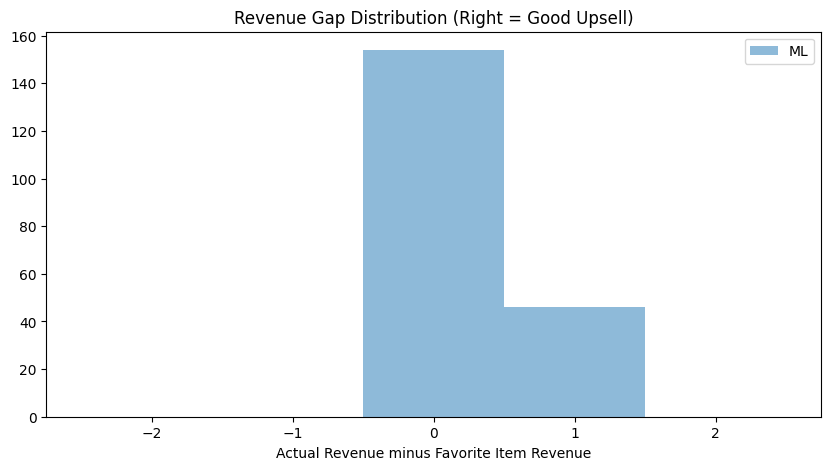

In [9]:
# =============================================================================
# EXTENSION 2: REVENUE GAP ANALYSIS
# =============================================================================
def analyze_revenue_gap(report_df, users_df, restaurants_df):
    gap_data = []

    for _, row in report_df.iterrows():
        u_id = row['User ID'] if 'User ID' in row else row['user_id']
        actual_rev = row['Revenue']

        # Find True Favorite Price
        user = users_df[users_df['user_id'] == u_id].iloc[0]
        best_util = -np.inf
        fav_price = 0

        for _, rest in restaurants_df.iterrows():
            # Use your GT Utility function here
            # (Replace get_gt_utility with get_gt_features_and_utility if needed)
            u = get_gt_utility(user, rest)
            if u > best_util:
                best_util = u
                fav_price = rest['price_level']

        # Calculate Gap: (Actual - Favorite)
        # Positive = You upsold them!
        # Negative = You undersold them (or they settled for less)
        gap_data.append(actual_rev - fav_price)

    return pd.Series(gap_data)

# Calculate Gaps
ml_gaps = analyze_revenue_gap(ml_report_df, users, restaurants)

print(f"ML  Avg Upsell: ${ml_gaps.mean():.2f}")

# Visualize
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.hist(ml_gaps, alpha=0.5, label='ML', bins=[-2.5, -1.5, -0.5, 0.5, 1.5, 2.5])
plt.legend()
plt.title("Revenue Gap Distribution (Right = Good Upsell)")
plt.xlabel("Actual Revenue minus Favorite Item Revenue")
plt.show()

In [10]:
# =============================================================================
# EXTENSION 3: PRICE SENSITIVITY MATRIX (ML VERSION)
# =============================================================================

# 1. Merge Tolerance into the ML report
# Note: Check if your ML report uses 'User ID' or 'user_id'
uid_col = 'User ID' if 'User ID' in ml_report_df.columns else 'user_id'

merged_ml = ml_report_df.merge(users[['user_id', 'price_tolerance']], left_on=uid_col, right_on='user_id')

print("--- ML: User Tolerance vs Chosen Price ---")
# 2. Create the Cross-Tabulation
matrix_ml = pd.crosstab(
    merged_ml['price_tolerance'],
    merged_ml['Revenue'],
    rownames=['User Tolerance'],
    colnames=['Chosen Price']
)

display(matrix_ml)

# 3. Calculate "Upsell Rate" (Percentage of users buying ABOVE their tolerance)
# Note: This is rare because penalty is high, but interesting to check.
upsells = merged_ml[merged_ml['Revenue'] > merged_ml['price_tolerance']].shape[0]
print(f"\nTotal users forced to buy ABOVE tolerance: {upsells}")

--- ML: User Tolerance vs Chosen Price ---


Chosen Price,1,2,3
User Tolerance,,,
1,31,44,0
2,0,65,0
3,0,25,35



Total users forced to buy ABOVE tolerance: 44
